In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), ".."))

In [4]:
from system.controller.reachability_estimator.networks import Model, get_grid_cell
from system.controller.reachability_estimator.ReachabilityDataset import SampleConfig
from system.controller.reachability_estimator.training.train_multiframe_dst import _load_weights, DATA_STORAGE_FOLDER, Hyperparameters, process_batch

config = SampleConfig(
    grid_cell_spikings=False,
    lidar=False,
    images=False,
    dist=True,
)
network_config = {
    'image_encoder': 'conv',
}
dataset_features = []

dataset_features = ''.join(f'-{feature}' for feature in dataset_features)
suffix = dataset_features + config.suffix()
if network_config['image_encoder'] == 'conv':
    suffix += '+conv'

model_filename = "reachability_network"
model_dir = DATA_STORAGE_FOLDER

model_filename = model_filename + suffix
model_file = os.path.join(model_dir, model_filename)

nets = Model.create_from_config("convolutional", config, **network_config)
epoch = _load_weights(model_file, nets)
print("Loaded epoch", epoch)

Loaded epoch 25


In [5]:
nets.nets

{'angle_regression': AngleRegression(
   (fc): Linear(in_features=4, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 'position_regression': PositionRegression(
   (fc): Linear(in_features=4, out_features=2, bias=True)
 ),
 'reachability_regression': ReachabilityRegression(
   (fc): Linear(in_features=4, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 'fully_connected': FCLayers(
   (fc): Sequential(
     (0): Linear(in_features=3, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
     (4): Linear(in_features=256, out_features=4, bias=True)
   )
 )}

In [4]:
from system.controller.reachability_estimator.ReachabilityDataset import ReachabilityDataset
from system.controller.reachability_estimator.types import img_reshape, Sample
import torch

In [5]:
dataset = ReachabilityDataset("dataset.hd5", sample_config=config)

In [6]:
idx = 2024

sample, reachable = dataset.sample(idx)
model_args, ground_truth = dataset[idx]
model_args = [ arg.unsqueeze(0) for arg in model_args ] # make it a batch

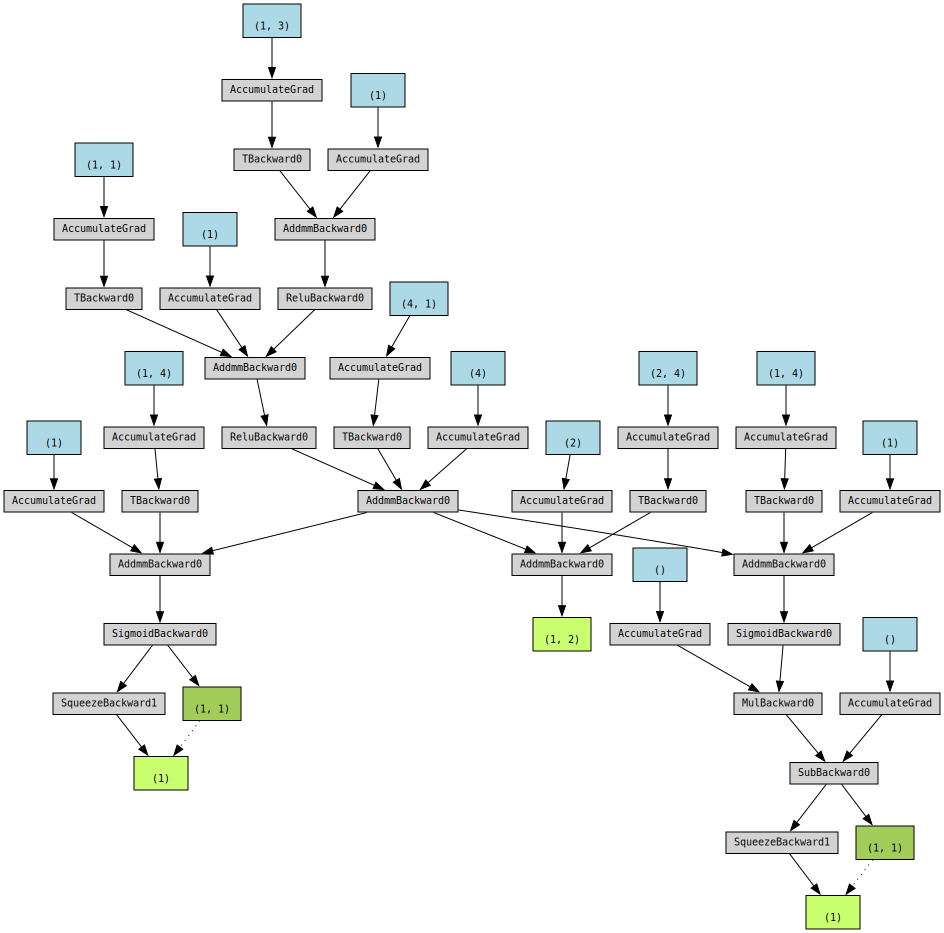

In [7]:
from torchviz import make_dot

result = nets.get_prediction(*model_args)
make_dot(result)

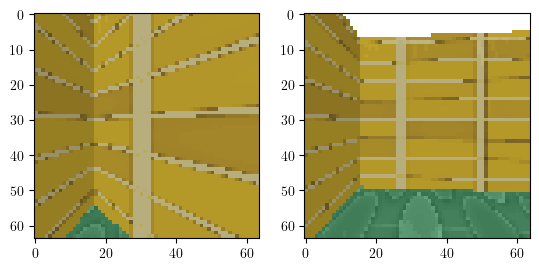

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
axes[0].imshow(sample.src.img)
axes[1].imshow(sample.dst.img)

In [9]:
src_imgs, dst_imgs = model_args[0:2]

# see networks.py
src_imgs = src_imgs.transpose(1, 3).transpose(2, 3)
dst_imgs = dst_imgs.transpose(1, 3).transpose(2, 3)
x_images = torch.cat([src_imgs, dst_imgs, src_imgs - dst_imgs], dim=1)

x_images = nets.nets['img_encoder'].layers[0](x_images)
x_images.shape

torch.Size([1, 64, 30, 30])

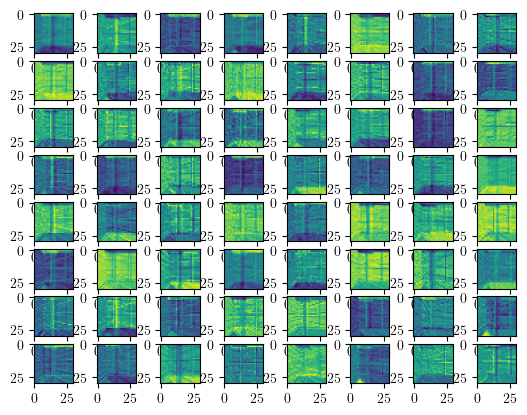

In [10]:
images = x_images.detach().numpy()[0]

fig, axes = plt.subplots(8, 8)
axes = axes.flatten()
for conv, ax in zip(images, axes):
    ax.imshow(conv)

In [11]:
layer1convs = nets.nets['img_encoder'].layers[0].weight.detach().numpy()
layer1convs.shape

(64, 12, 5, 5)

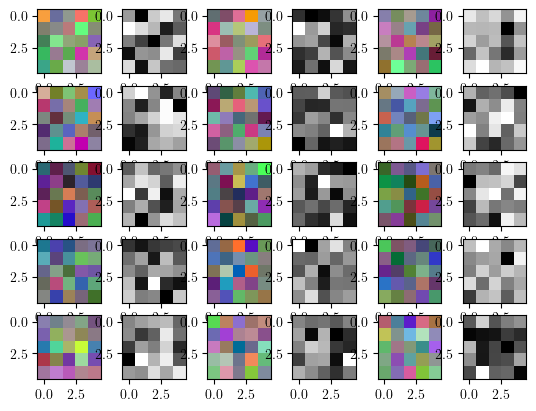

In [13]:
import numpy as np

fig, axes = plt.subplots(5, 6)

def normalize(array):
    array = array - np.min(array)
    array = array / np.max(array)
    return array

for ax, filter_ in zip(axes, layer1convs):
    filter_normalized = normalize(filter_)
    for i in range(3):
        filter_depth_img = filter_normalized[i*4: (i+1)*4]
        img, depth = filter_depth_img[:3], filter_depth_img[3]
        ax[i*2].imshow(img.transpose((1, 2, 0)))
        ax[i*2+1].imshow(depth, cmap='gray')

In [14]:
with torch.no_grad():
    x_lidar = model_args[5:7]
    x_lidar = nets.nets['lidar_encoder'](*x_lidar)
    print(x_lidar)

    x_spikings = model_args[3:5]
    x_spikings = get_grid_cell(*x_spikings)
    print(x_spikings) # Note: this is a loss, so 0 is very good

    if config.images:
        x_images = model_args[0:2]
        x_images = nets.nets['img_encoder'](*x_images)
        if network_config['with_conv_layer']:
            x_images = nets.nets['conv_encoder'](x_images.view(1, -1, 1))
        #print(x_images)

    x = torch.cat((x_lidar, x_spikings, x_images), dim=1)

tensor([[-0.3758, -0.0786,  0.2005, -0.1083, -0.7949,  0.4243,  0.6364, -0.3113,
          0.6352,  0.1305]])
tensor([[0.]])


In [15]:
with torch.no_grad():
    x = nets.nets['fully_connected'](x)
x

tensor([[ 0.1539,  0.1772, -2.7813, -0.6887]])

In [16]:
with torch.no_grad():
    reachability = nets.nets['reachability_regression'](x)
    position = nets.nets['position_regression'](x)
    angle = nets.nets['angle_regression'](x)
reachability, position, angle

(tensor([0.1417]), tensor([[1.3981, 0.0125]]), tensor([0.0965]))

In [17]:
with torch.no_grad():
    prediction = nets.get_prediction(*model_args)
prediction

(tensor([0.1172]), tensor([[-0.2041, -0.0746]]), tensor([0.7012]))

In [18]:
ground_truth

(tensor(0.), tensor([-0.1781, -0.0037]), tensor(-0.2800))

In [20]:
nets.nets['reachability_regression']

ReachabilityRegression(
  (fc): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [22]:
nets.nets['reachability_regression'].fc.weight

Parameter containing:
tensor([[-0.6935, -0.3772,  0.4875,  0.3754]], requires_grad=True)

In [23]:
nets.nets['position_regression'].fc.weight

Parameter containing:
tensor([[ 0.3004, -0.2464, -0.6591,  0.6362],
        [ 0.1209, -0.9178,  0.0347, -0.3674]], requires_grad=True)

In [24]:
nets.nets['angle_regression'].fc.weight

Parameter containing:
tensor([[ 0.7155, -0.4985,  0.1068, -0.4767]], requires_grad=True)

In [29]:
# without torch.no_grad():
grad = None
def get_grad():
    grad = g
prediction = nets.get_prediction(*model_args)
nets.ne.register_hook(get_grad)
grad

RuntimeError: cannot register a hook on a tensor that doesn't require gradient